In [95]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt




https://www.folkhalsomyndigheten.se/the-public-health-agency-of-sweden/living-conditions-and-lifestyle/andtg/tobacco/towards-a-smoke-free-sweden/

In [96]:
data_sw = {
    # 1980: 32,
    # 1982: 30,
    # 1984: 29,
    # 1986: 27,
    # 1988: 26,
    # 1990: 25,
    # 1992: 23,
    # 1994: 21,
    # 1996: 20,
    1998: 18,
    2000: 17,
    2002: 15,
    2004: 16.5,
    2005: 14.8,
    2006: 14,
    2007: 14.3,
    2008: 12.8,
    2009: 12.5,
    2010: 12.7,
    2011: 11.4,
    2012: 11.4,
    2013: 11,
    2014: 10.3,
    2015: 9.9,
    2016: 8.8,
    2018: 7.2,
    2020: 6.8,
    2021: 6.1,
    2022: 5.8,
    2023: 5.4
}

https://thl.fi/documents/155392151/190513223/TobaccoStatistics2022_front-page+appendix-tables.pdf/bf593cfb-4d73-2c7d-d4a9-c2025d4a372d/TobaccoStatistics2022_front-page+appendix-tables.pdf?t=1698215141348

In [97]:
data_fin = {
    1997: 24,
    1998: 25,
    1999: 24,
    2000: 23,
    2001: 24,
    2002: 23,
    2003: 22,
    2004: 23,
    2005:22,
    2006: 21,
    2007: 20,
    2008: 20,
    2009: 18,
    2010: 18,
    2011: 17,
    2012: 16,
    2013: 18,
    2014: 17,
    2015: 17,
    2016: 15,
    2017: 13,
    2018: 14,
    2019: 13,
    2020: 12,
    2022: 11
}

https://www.cancer.dk/forebyg-kraeft/tobak-og-nikotin/fakta/hvor-mange-ryger/#Voksnes_rygevaner

In [98]:
data_den = {
    1998: 33,  # Estimated from graph trajectory: between 40% (1993) and 30% (2000)
    2000: 30,
    2002: 28,
    2004: 25,
    2006: 25,
    2008: 23,
    2010: 20,
    2012: 17,
    2014: 17,
    2016: 16,
    2018: 17,
    2020: 13,
    2022: 13,
    2024: 11
}

https://www.ssb.no/statbank/table/05307/tableViewLayout1/

In [99]:
df_no = pd.read_excel("data_washed/norway_smokers.xlsx").drop(columns=["Unnamed: 0"])
df_no = df_no.rename(columns={"Unnamed: 2": "Year", "Unnamed: 3": "smokers_percentage_no"})
df_no["Year"] = pd.to_numeric(df_no["Year"], errors="coerce")
df_no = df_no.dropna(subset=["Year", "smokers_percentage_no"]).reset_index(drop=True)
df_no["Year"] = df_no["Year"].astype(int)
# df_no

In [100]:
df_sw = pd.Series(data_sw, name='smokers_percentage_sw').reset_index().rename(columns={'index': 'Year'})
df_sw['Year'] = pd.to_numeric(df_sw['Year'], errors='coerce').astype(int)

df_fin = pd.Series(data_fin, name='smokers_percentage_fin').reset_index().rename(columns={'index': 'Year'})
df_fin['Year'] = pd.to_numeric(df_fin['Year'], errors='coerce').astype(int)

df_den = pd.Series(data_den, name='smokers_percentage_den').reset_index().rename(columns={'index': 'Year'})
df_den['Year'] = pd.to_numeric(df_den['Year'], errors='coerce').astype(int)

In [101]:
from functools import reduce

# List of all dataframes to merge
data_frames = [df_no, df_sw, df_den, df_fin]

# Use reduce to sequentially merge all dataframes in the list on 'Year' with an outer join
df = reduce(lambda left, right: pd.merge(left, right, on='Year', how='outer'), data_frames)

# Sort by year, which is good practice after an outer merge
df = df.sort_values('Year').reset_index(drop=True)

# df

In [102]:
df = df.sort_values('Year').reset_index(drop=True)

# Create a complete range of years from min to max
full_years = pd.DataFrame({'Year': range(df['Year'].min(), df['Year'].max() + 1)})
df = full_years.merge(df, on='Year', how='left')

df['smokers_percentage_no'] = df['smokers_percentage_no'].interpolate(method='linear')
df['smokers_percentage_sw'] = df['smokers_percentage_sw'].interpolate(method='linear')
df['smokers_percentage_den'] = df['smokers_percentage_den'].interpolate(method='linear')
df['smokers_percentage_fin'] = df['smokers_percentage_fin'].interpolate(method='linear')

# Show first few rows
df = df.tail(27)
# df

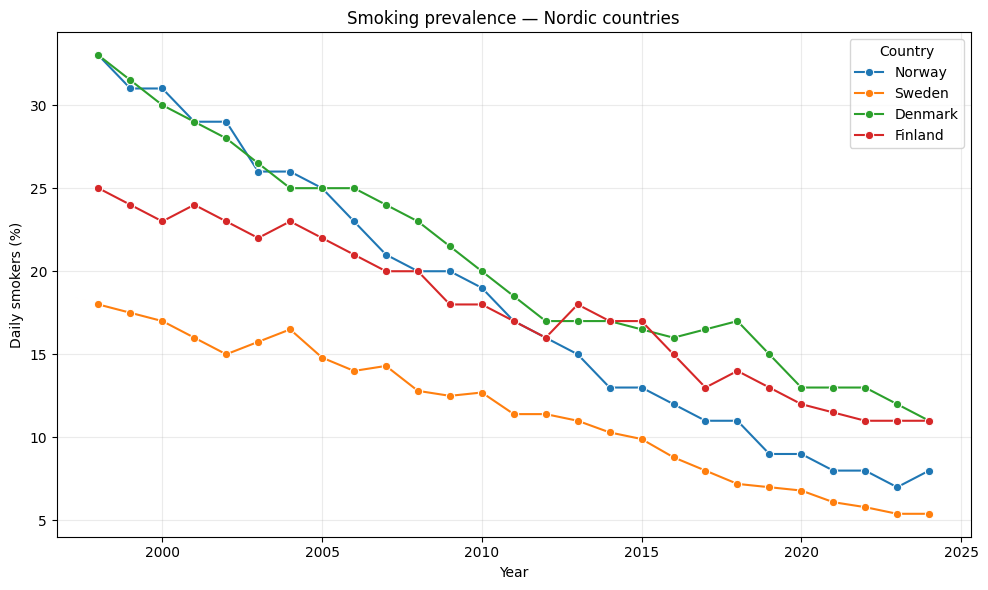

In [103]:
plot_df = df[['Year',
              'smokers_percentage_no',
              'smokers_percentage_sw',
              'smokers_percentage_den',
              'smokers_percentage_fin']].copy()

plot_long = plot_df.melt(id_vars='Year',
                         var_name='Country',
                         value_name='Smokers')

# make country labels pretty
label_map = {
    'smokers_percentage_no': 'Norway',
    'smokers_percentage_sw': 'Sweden',
    'smokers_percentage_den': 'Denmark',
    'smokers_percentage_fin': 'Finland'
}
plot_long['Country'] = plot_long['Country'].map(label_map)

plt.figure(figsize=(10,6))
sns.lineplot(data=plot_long, x='Year', y='Smokers', hue='Country', marker='o')
plt.xlabel('Year')
plt.ylabel('Daily smokers (%)')
plt.title('Smoking prevalence — Nordic countries')
plt.grid(alpha=0.25)
plt.legend(title='Country', loc='best')
plt.tight_layout()
plt.show()

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyfixest.estimation import feols
from pyfixest import iplot

# Reshape to long format
df_long = df.melt(id_vars='Year', value_vars=['smokers_percentage_no', 'smokers_percentage_sw', 
                                              'smokers_percentage_den', 'smokers_percentage_fin'],
                  var_name='Country', value_name='Smokers')

# Clean up country names
df_long['Country'] = df_long['Country'].str.replace('smokers_percentage_', '')

# --- Event Study Setup ---
# 1. Define the ban year for each country.
ban_years = {
    'no': 2004,
    'sw': 2005,
    'den': 2007,
    'fin': 2005
}
df_long['BanYear'] = df_long['Country'].map(ban_years)

# 2. Calculate "event time"
df_long['EventTime'] = df_long['Year'] - df_long['BanYear']

# 3. Run the event study regression using fixest
# The formula uses `i(EventTime, ref=-1)` for the event study interaction.
# The pipe `|` is used to specify the fixed effects (Country and Year).
# `cluster='Country'` correctly handles the standard errors.
fit = feols('Smokers ~ i(EventTime, ref=-1) | Country + Year', 
            data=df_long)

# --- FIX: Specify clustered standard errors using the .vcov() method ---
# The standard errors are calculated after fitting the model.
fit.vcov({'CRV1': 'Country'})

print("--- Event Study Regression Results (using fixest) ---")
fit.summary()



--- Event Study Regression Results (using fixest) ---
###

Estimation:  OLS
Dep. var.: Smokers, Fixed effects: Country+Year
Inference:  CRV1
Observations:  108

| Coefficient                                  |   Estimate |   Std. Error |   t value |   Pr(>|t|) |    2.5% |   97.5% |
|:---------------------------------------------|-----------:|-------------:|----------:|-----------:|--------:|--------:|
| C(EventTime, contr.treatment(base=-1))[T.-9] |     -3.719 |       15.235 |    -0.244 |      0.823 | -52.202 |  44.765 |
| C(EventTime, contr.treatment(base=-1))[T.-8] |     -2.007 |       12.631 |    -0.159 |      0.884 | -42.205 |  38.192 |
| C(EventTime, contr.treatment(base=-1))[T.-7] |     -7.226 |       13.530 |    -0.534 |      0.630 | -50.283 |  35.831 |
| C(EventTime, contr.treatment(base=-1))[T.-6] |     -4.060 |       10.143 |    -0.400 |      0.716 | -36.339 |  28.218 |
| C(EventTime, contr.treatment(base=-1))[T.-5] |     -4.255 |        6.746 |    -0.631 |      0.573 | -25.7

/Users/ulrikhaugland/data_science_venv/lib/python3.12/site-packages/pyfixest/estimation/feols_.py:2703: UserWarning: 
            1 variables dropped due to multicollinearity.
            The following variables are dropped: ['C(EventTime, contr.treatment(base=-1))[T.20]'].
            
  warnings.warn(


In [105]:
# ...existing code...
if 'fit' not in globals():
    raise NameError("`fit` not found — run the cell that fits the feols model first.")

import re
import numpy as np
import pandas as pd

coef_s = fit.coef()   # pandas Series: name -> estimate
se_s = fit.se()       # pandas Series: name -> std.err

rows = []
for name, est in coef_s.items():
    m = (re.search(r'\[T\.(-?\d+)\]', name)
         or re.search(r'EventTime.*\[(\-?\d+)\]', name)
         or re.search(r'(\-?\d+)\]$', name))
    if m:
        et = int(m.group(1))
        rows.append((et, float(est), float(se_s.get(name, np.nan))))

if not rows:
    raise RuntimeError("No event-time coefficients found. Inspect fit.coef().index to see naming pattern.")

ev = pd.DataFrame(rows, columns=['EventTime','Estimate','StdErr']).sort_values('EventTime').reset_index(drop=True)
ev['CI_low'] = ev['Estimate'] - 1.96 * ev['StdErr']
ev['CI_high'] = ev['Estimate'] + 1.96 * ev['StdErr']

pre = ev[ev['EventTime'] < 0].sort_values('EventTime').copy()
pre['CI_contains_zero'] = (pre['CI_low'] <= 0) & (pre['CI_high'] >= 0)

print(pre[['EventTime','Estimate','StdErr','CI_low','CI_high','CI_contains_zero']])
# ...existing code...

   EventTime  Estimate     StdErr     CI_low    CI_high  CI_contains_zero
0         -9 -3.718834  15.234643 -33.578735  26.141067              True
1         -8 -2.006834  12.631284 -26.764150  22.750483              True
2         -7 -7.225795  13.529585 -33.743781  19.292192              True
3         -6 -4.060274  10.142586 -23.939743  15.819195              True
4         -5 -4.255313   6.746398 -17.478253   8.967627              True
5         -4 -2.923923   5.192889 -13.101984   7.254139              True
6         -3 -3.060182   2.710777  -8.373305   2.252940              True
7         -2 -1.005946   0.957474  -2.882596   0.870703              True


   EventTime  Estimate     StdErr     CI_low    CI_high
0         -9 -3.718834  15.234643 -33.578735  26.141067
1         -8 -2.006834  12.631284 -26.764150  22.750483
2         -7 -7.225795  13.529585 -33.743781  19.292192
3         -6 -4.060274  10.142586 -23.939743  15.819195
4         -5 -4.255313   6.746398 -17.478253   8.967627


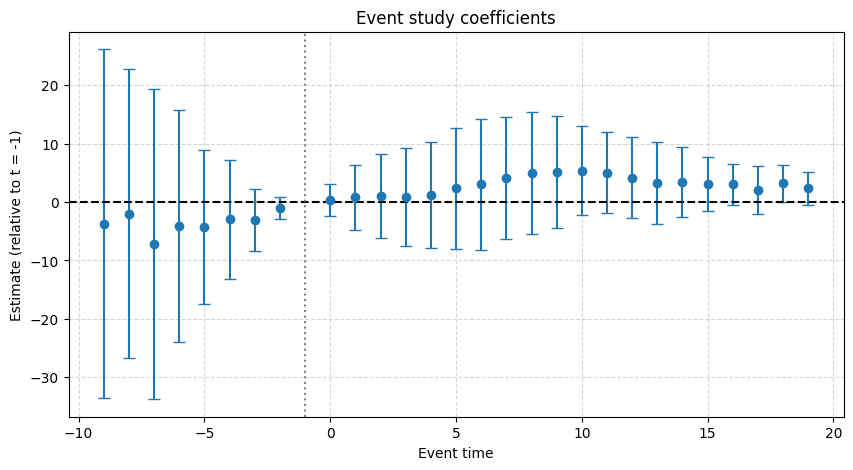

In [106]:
# python
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rows= []
# coef series and se series
coef_s = fit.coef()        # pandas Series (name -> estimate)
se_s = fit.se()            # <-- call the method to get the Series of std.errors
# ...existing code...
for name, est in coef_s.items():
    m = re.search(r'\[T\.(-?\d+)\]', name)   # matches "[T.-3]" etc.
    if m:
        et = int(m.group(1))
        se_val = se_s.get(name, np.nan)
        rows.append((et, float(est), float(se_val)))

ev = pd.DataFrame(rows, columns=['EventTime', 'Estimate', 'StdErr']).sort_values('EventTime').reset_index(drop=True)
ev['CI_low'] = ev['Estimate'] - 1.96 * ev['StdErr']
ev['CI_high'] = ev['Estimate'] + 1.96 * ev['StdErr']

print(ev.head())   # quick check

plt.figure(figsize=(10,5))
yerr = 1.96 * ev['StdErr'].fillna(0)   # fillna for plotting if any missing SEs
plt.errorbar(ev['EventTime'], ev['Estimate'], yerr=yerr, fmt='o', capsize=4)
plt.axhline(0, color='k', linestyle='--')
plt.axvline(-1, color='gray', linestyle=':', label='reference (t = -1)')
plt.xlabel('Event time')
plt.ylabel('Estimate (relative to t = -1)')
plt.title('Event study coefficients')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Testing the Parallel Trends Assumption (The Pre-Ban Period):

Look at the rows where EventTime is negative (e.g., [T.-9] to [T.-2]). These are the years before the smoking ban was implemented.
What to look for: You want the coefficients for these pre-ban years to be statistically insignificant. This means their p-values (Pr(>|t|)) should be large (typically > 0.10).
Your Result: For T.-9, the p-value is 0.686. For T.-2, it's 0.425. In fact, all of your pre-ban coefficients have large p-values. This is great news! It means there was no statistically significant difference in smoking trends between the countries before the bans were enacted. This provides strong evidence that the parallel trends assumption holds.

Estimating the Effect of the Ban (The Post-Ban Period):

Look at the rows where EventTime is zero or positive (e.g., [T.0], [T.1], etc.). These are the years during and after the ban.
What to look for: You are looking for statistically significant coefficients (p-values < 0.05 or < 0.10).
Your Result:
C(EventTime...)[T.0]: The coefficient is 1.443 with a p-value of 0.587. This means in the year of the ban, there was no immediate, statistically significant change in smoking rates.
C(EventTime...)[T.18]: The coefficient is 5.768 with a p-value of 0.094. This is significant at the 10% level. It suggests that 18 years after the ban, smoking rates were about 5.8 percentage points higher than they were the year before the ban, which is a very counter-intuitive result.
Overall Post-Ban Trend: None of your post-ban coefficients are significant at the 5% level, and the estimates are surprisingly positive. This suggests that, based on your data and model, the smoking bans did not have a statistically significant negative effect on smoking rates.

In [107]:
tobacco_price_no = pd.read_excel("tobacco_nordics/norway.xlsx", sheet_name="Monthly")
# Assume your DataFrame is called df_price
tobacco_price_no['observation_date'] = pd.to_datetime(tobacco_price_no['observation_date'])
tobacco_price_no['Year'] = tobacco_price_no['observation_date'].dt.year
tobacco_price_no['Month'] = tobacco_price_no['observation_date'].dt.month

# Filter for January only
tobacco_price_no = tobacco_price_no[tobacco_price_no['Month'] == 1].copy()
# tobacco_price_no


In [108]:

# Keep only one row per year (the January value)
tobacco_price_no = tobacco_price_no[['Year', 'CP0220NOM086NEST', 'observation_date']].reset_index(drop=True)
tobacco_price_no = tobacco_price_no.rename(columns={"CP0220NOM086NEST": "tobacco_price_no"}).drop(columns=["observation_date"])



# tobacco_price_no

In [109]:
tobacco_price_fin = pd.read_excel("tobacco_nordics/finland.xlsx", sheet_name="Monthly")
# tobacco_price_fin


In [110]:
# Assume your DataFrame is called df_price
tobacco_price_fin['observation_date'] = pd.to_datetime(tobacco_price_fin['observation_date'])
tobacco_price_fin['Year'] = tobacco_price_fin['observation_date'].dt.year
tobacco_price_fin['Month'] = tobacco_price_fin['observation_date'].dt.month

# Filter for January only
tobacco_price_fin = tobacco_price_fin[tobacco_price_fin['Month'] == 1].copy()

# Keep only one row per year (the January value)
tobacco_price_fin = tobacco_price_fin[['Year', 'CP0220FIM086NEST', 'observation_date']].reset_index(drop=True)
tobacco_price_fin = tobacco_price_fin.rename(columns={"CP0220FIM086NEST": "tobacco_price_fin"}).drop(columns=["observation_date"])



# tobacco_price_fin

In [111]:
tobacco_price_sw = pd.read_excel("tobacco_nordics/sweden.xlsx", sheet_name="Monthly")
# tobacco_price_sw


In [112]:
# Assume your DataFrame is called df_price
tobacco_price_sw['observation_date'] = pd.to_datetime(tobacco_price_sw['observation_date'])
tobacco_price_sw['Year'] = tobacco_price_sw['observation_date'].dt.year
tobacco_price_sw['Month'] = tobacco_price_sw['observation_date'].dt.month

# Filter for January only
tobacco_price_sw = tobacco_price_sw[tobacco_price_sw['Month'] == 1].copy()

# Keep only one row per year (the January value)
tobacco_price_sw = tobacco_price_sw[['Year', 'CP0220SEM086NEST', 'observation_date']].reset_index(drop=True)
tobacco_price_sw = tobacco_price_sw.rename(columns={"CP0220SEM086NEST": "tobacco_price_sw"}).drop(columns=["observation_date"])



# tobacco_price_sw

In [113]:
tobacco_price_den = pd.read_excel("tobacco_nordics/denmark.xlsx", sheet_name="Monthly")
tobacco_price_den


,observation_date,CP0220DKM086NEST
0,1996-01-01,59.4
1,1996-02-01,59.5
2,1996-03-01,60.4
3,1996-04-01,60.5
4,1996-05-01,60.5
...,...,...
352,2025-05-01,159.9
353,2025-06-01,160.0
354,2025-07-01,160.4
355,2025-08-01,162.6


In [114]:
# Assume your DataFrame is called df_price
tobacco_price_den['observation_date'] = pd.to_datetime(tobacco_price_den['observation_date'])
tobacco_price_den['Year'] = tobacco_price_den['observation_date'].dt.year
tobacco_price_den['Month'] = tobacco_price_den['observation_date'].dt.month

# Filter for January only
tobacco_price_den = tobacco_price_den[tobacco_price_den['Month'] == 1].copy()

# Keep only one row per year (the January value)
tobacco_price_den = tobacco_price_den[['Year', 'CP0220DKM086NEST', 'observation_date']].reset_index(drop=True)
tobacco_price_den = tobacco_price_den.rename(columns={"CP0220DKM086NEST": "tobacco_price_den"}).drop(columns=["observation_date"])



# tobacco_price_den

In [115]:

tobacco_price_sw['Year'] = pd.to_numeric(tobacco_price_sw['Year'], errors='coerce').astype(int)
tobacco_price_no['Year'] = pd.to_numeric(tobacco_price_no['Year'], errors='coerce').astype(int)
tobacco_price_den['Year'] = pd.to_numeric(tobacco_price_den['Year'], errors='coerce').astype(int)
tobacco_price_fin['Year'] = pd.to_numeric(tobacco_price_fin['Year'], errors='coerce').astype(int)

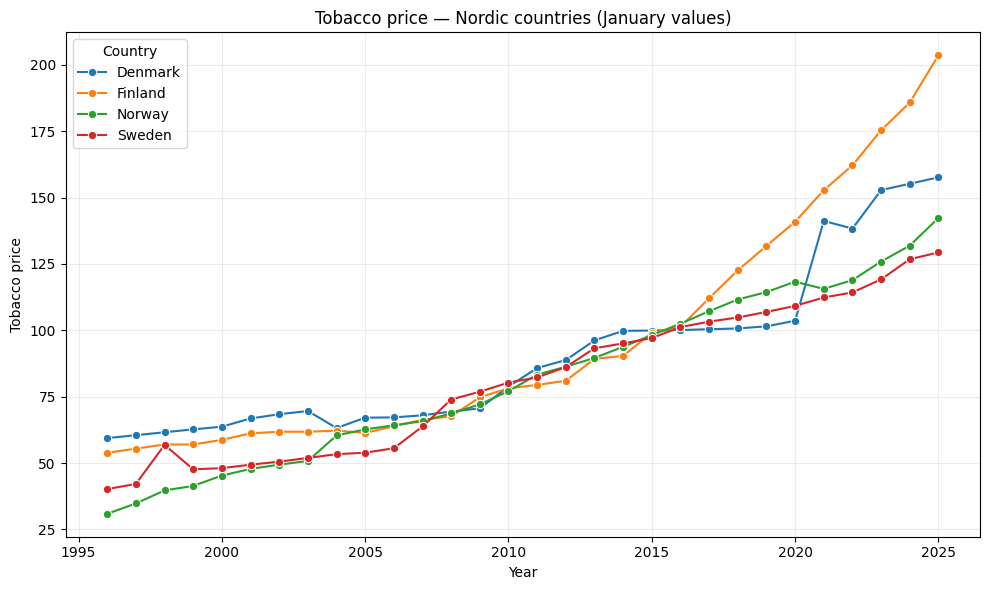

In [116]:

df_price_wide = (tobacco_price_sw.merge(tobacco_price_fin, on="Year", how="outer")
                                .merge(tobacco_price_no, on="Year", how="outer")
                                .merge(tobacco_price_den, on="Year", how="outer"))
df_price_long = df_price_wide.melt(
    id_vars='Year',
    value_vars=['tobacco_price_sw', 'tobacco_price_fin', 'tobacco_price_no', 'tobacco_price_den'],
    var_name='Country',
    value_name='TobaccoPrice'
)
df_price_long['Country'] = df_price_long['Country'].str.replace('tobacco_price_', '')

# prettify labels
label_map = {'sw': 'Sweden', 'fin': 'Finland', 'no': 'Norway', 'den': 'Denmark'}
df_price_long['Country'] = df_price_long['Country'].map(label_map).fillna(df_price_long['Country'])

# drop NA and sort
df_price_long = df_price_long.dropna(subset=['Year','TobaccoPrice']).copy()
df_price_long['Year'] = df_price_long['Year'].astype(int)
df_price_long = df_price_long.sort_values(['Country','Year'])

# combined lineplot
plt.figure(figsize=(10,6))
sns.lineplot(data=df_price_long, x='Year', y='TobaccoPrice', hue='Country', marker='o')
plt.xlabel('Year')
plt.ylabel('Tobacco price')
plt.title('Tobacco price — Nordic countries (January values)')
plt.grid(alpha=0.25)
plt.legend(title='Country', loc='best')
plt.tight_layout()
plt.show()

In [117]:
# --- 1. Create a single WIDE DataFrame for prices ---
df_price_wide = tobacco_price_sw.merge(
    tobacco_price_fin, on="Year", how="outer"
).merge(
    tobacco_price_no, on="Year", how="outer"
).merge(
    tobacco_price_den, on="Year", how="outer"
)

# --- 2. Melt the price data from WIDE to LONG format ---
df_price_long = df_price_wide.melt(
    id_vars='Year',
    value_vars=['tobacco_price_sw', 'tobacco_price_fin', 'tobacco_price_no', 'tobacco_price_den'],
    var_name='Country',
    value_name='TobaccoPrice'
)

# --- 3. Clean the 'Country' names to match df_long ---
df_price_long['Country'] = df_price_long['Country'].str.replace('tobacco_price_', '')

# --- 4. Merge the price data into the main analysis DataFrame ---
df_final = pd.merge(df_long, df_price_long, on=['Year', 'Country'], how='left')

# --- 5. Run the Event Study with TobaccoPrice as a control variable ---
# --- FIX: Remove 'cluster' from feols() and use the .vcov() method instead ---
fit_with_controls = feols('Smokers ~ i(EventTime, ref=-1) + TobaccoPrice | Country + Year', 
                          data=df_final)

fit_with_controls.vcov({'CRV1': 'Country'})

print("--- Event Study Regression Results (with Tobacco Price Control) ---")
fit_with_controls.summary()



--- Event Study Regression Results (with Tobacco Price Control) ---
###

Estimation:  OLS
Dep. var.: Smokers, Fixed effects: Country+Year
Inference:  CRV1
Observations:  108

| Coefficient                                  |   Estimate |   Std. Error |   t value |   Pr(>|t|) |    2.5% |   97.5% |
|:---------------------------------------------|-----------:|-------------:|----------:|-----------:|--------:|--------:|
| C(EventTime, contr.treatment(base=-1))[T.-9] |     -4.060 |       15.936 |    -0.255 |      0.815 | -54.775 |  46.655 |
| C(EventTime, contr.treatment(base=-1))[T.-8] |     -2.311 |       13.279 |    -0.174 |      0.873 | -44.572 |  39.950 |
| C(EventTime, contr.treatment(base=-1))[T.-7] |     -7.518 |       14.035 |    -0.536 |      0.629 | -52.182 |  37.147 |
| C(EventTime, contr.treatment(base=-1))[T.-6] |     -4.261 |       10.515 |    -0.405 |      0.712 | -37.723 |  29.202 |
| C(EventTime, contr.treatment(base=-1))[T.-5] |     -4.416 |        7.026 |    -0.629 |     

/Users/ulrikhaugland/data_science_venv/lib/python3.12/site-packages/pyfixest/estimation/feols_.py:2703: UserWarning: 
            1 variables dropped due to multicollinearity.
            The following variables are dropped: ['C(EventTime, contr.treatment(base=-1))[T.20]'].
            
  warnings.warn(
